In [1]:
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *        
from keras.applications.vgg16 import VGG16
import keras




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# reading the data
import natsort
Train_image_list = natsort.natsorted(glob.glob('/content/drive/MyDrive/Dataset/Brain scans/Tumor/TRAIN' + '/*.jpg'))
Train_label_list = natsort.natsorted(glob.glob('/content/drive/MyDrive/Dataset/Brain scans/Tumor/TRAIN_masks' + '/*.png'))


test_image_list = natsort.natsorted(glob.glob('/content/drive/MyDrive/Dataset/Brain scans/Tumor/TEST' + '/*.jpg'))
test_label_list = natsort.natsorted(glob.glob('/content/drive/MyDrive/Dataset/Brain scans/Tumor/TEST_masks' + '/*.png'))

In [4]:
height = 256
width  = 256
channels = 3

In [5]:
# It contains 500 training samples 
Train_img = np.zeros([500, height, width, channels])
Train_mask = np.zeros([500, height, width])


for i in range(len(Train_image_list)):
    img_path = Train_image_list[i]
    img = cv2.imread(img_path)
    img = np.double(cv2.resize(img, (height, width)))
    Train_img[i,:,:,:] = img

    label_path = Train_label_list[i]    
    img_2 = cv2.imread(label_path)
    img_2 = cv2.resize(img_2, (height, width))
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    Train_mask[i,:,:] = img_2

In [6]:
# It contains 100 test samples for 
Test_img = np.zeros([100, height, width, channels])
Test_mask = np.zeros([100, height, width])


for i in range(len(test_image_list)):
    img_path = test_image_list[i]
    img = cv2.imread(img_path)
    img = np.double(cv2.resize(img, (height, width)))   
    Test_img[i,:,:,:] = img

    label_path = test_label_list[i]    
    img_2 = cv2.imread(label_path)
    img_2 = cv2.resize(img_2, (height, width))
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    Test_mask[i,:,:] = img_2

In [7]:
print(Train_img.shape,Train_mask.shape,Test_img.shape,Test_mask.shape)

(500, 256, 256, 3) (500, 256, 256) (100, 256, 256, 3) (100, 256, 256)


In [52]:
Train_img[9,120,72]

array([0.28627451, 0.28627451, 0.28627451])

In [8]:
Train_img = Train_img / 255
Test_img = Test_img /255

In [9]:
Train_mask   = Train_mask /255.
Test_mask   = Test_mask /255.

In [10]:
Train_mask = np.expand_dims(Train_mask, axis=3)
Test_mask = np.expand_dims(Test_mask, axis=3)

In [11]:
print(Train_img.shape,Train_mask.shape,Test_img.shape,Test_mask.shape)

(500, 256, 256, 3) (500, 256, 256, 1) (100, 256, 256, 3) (100, 256, 256, 1)


In [18]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',iou_coef,dice_coef])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Model 

In [12]:
input_size = (256,256,3)
inputs = Input(input_size)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

In [19]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',iou_coef,dice_coef])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Training

In [21]:
batch_size = 8
nb_epoch = 100

In [22]:
history = model.fit(Train_img,Train_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,validation_split = 0.1,     
                   )

Epoch 1/100
57/57 [==============================] - 59s 733ms/step - loss: 0.2231 - accuracy: 0.9464 - iou_coef: 0.0503 - dice_coef: 0.0926 - val_loss: 0.2943 - val_accuracy: 0.9467 - val_iou_coef: 0.0886 - val_dice_coef: 0.1592
Epoch 2/100
57/57 [==============================] - 36s 637ms/step - loss: 0.1417 - accuracy: 0.9465 - iou_coef: 0.1373 - dice_coef: 0.2306 - val_loss: 0.2147 - val_accuracy: 0.9467 - val_iou_coef: 0.1159 - val_dice_coef: 0.2021
Epoch 3/100
57/57 [==============================] - 37s 641ms/step - loss: 0.1290 - accuracy: 0.9465 - iou_coef: 0.1631 - dice_coef: 0.2682 - val_loss: 0.2898 - val_accuracy: 0.9467 - val_iou_coef: 0.0975 - val_dice_coef: 0.1731
Epoch 4/100
57/57 [==============================] - 37s 650ms/step - loss: 0.1183 - accuracy: 0.9465 - iou_coef: 0.1888 - dice_coef: 0.3046 - val_loss: 0.2241 - val_accuracy: 0.9467 - val_iou_coef: 0.1223 - val_dice_coef: 0.2116
Epoch 5/100
57/57 [==============================] - 37s 651ms/step - loss: 0.10

# Testing and evaluation

In [ ]:
# intersection over union(iou) or Jaccard Index
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  y_true = tf.cast(y_true, tf.float64) 
  y_pred = tf.cast(y_pred, tf.float64)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
# dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
  y_true = tf.cast(y_true, tf.float64) 
  y_pred = tf.cast(y_pred, tf.float64)
  intersection = K.sum(y_true * y_pred, axis=[1,2])
  union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [23]:
predictions = model.predict(Test_img, batch_size=8, verbose=1)

13/13 [==============================] - 5s 402ms/step


In [25]:
print(iou_coef(Test_mask, predictions))

tf.Tensor([0.41513786], shape=(1,), dtype=float64)


In [26]:
print(dice_coef(Test_mask, predictions))

tf.Tensor([0.56602765], shape=(1,), dtype=float64)


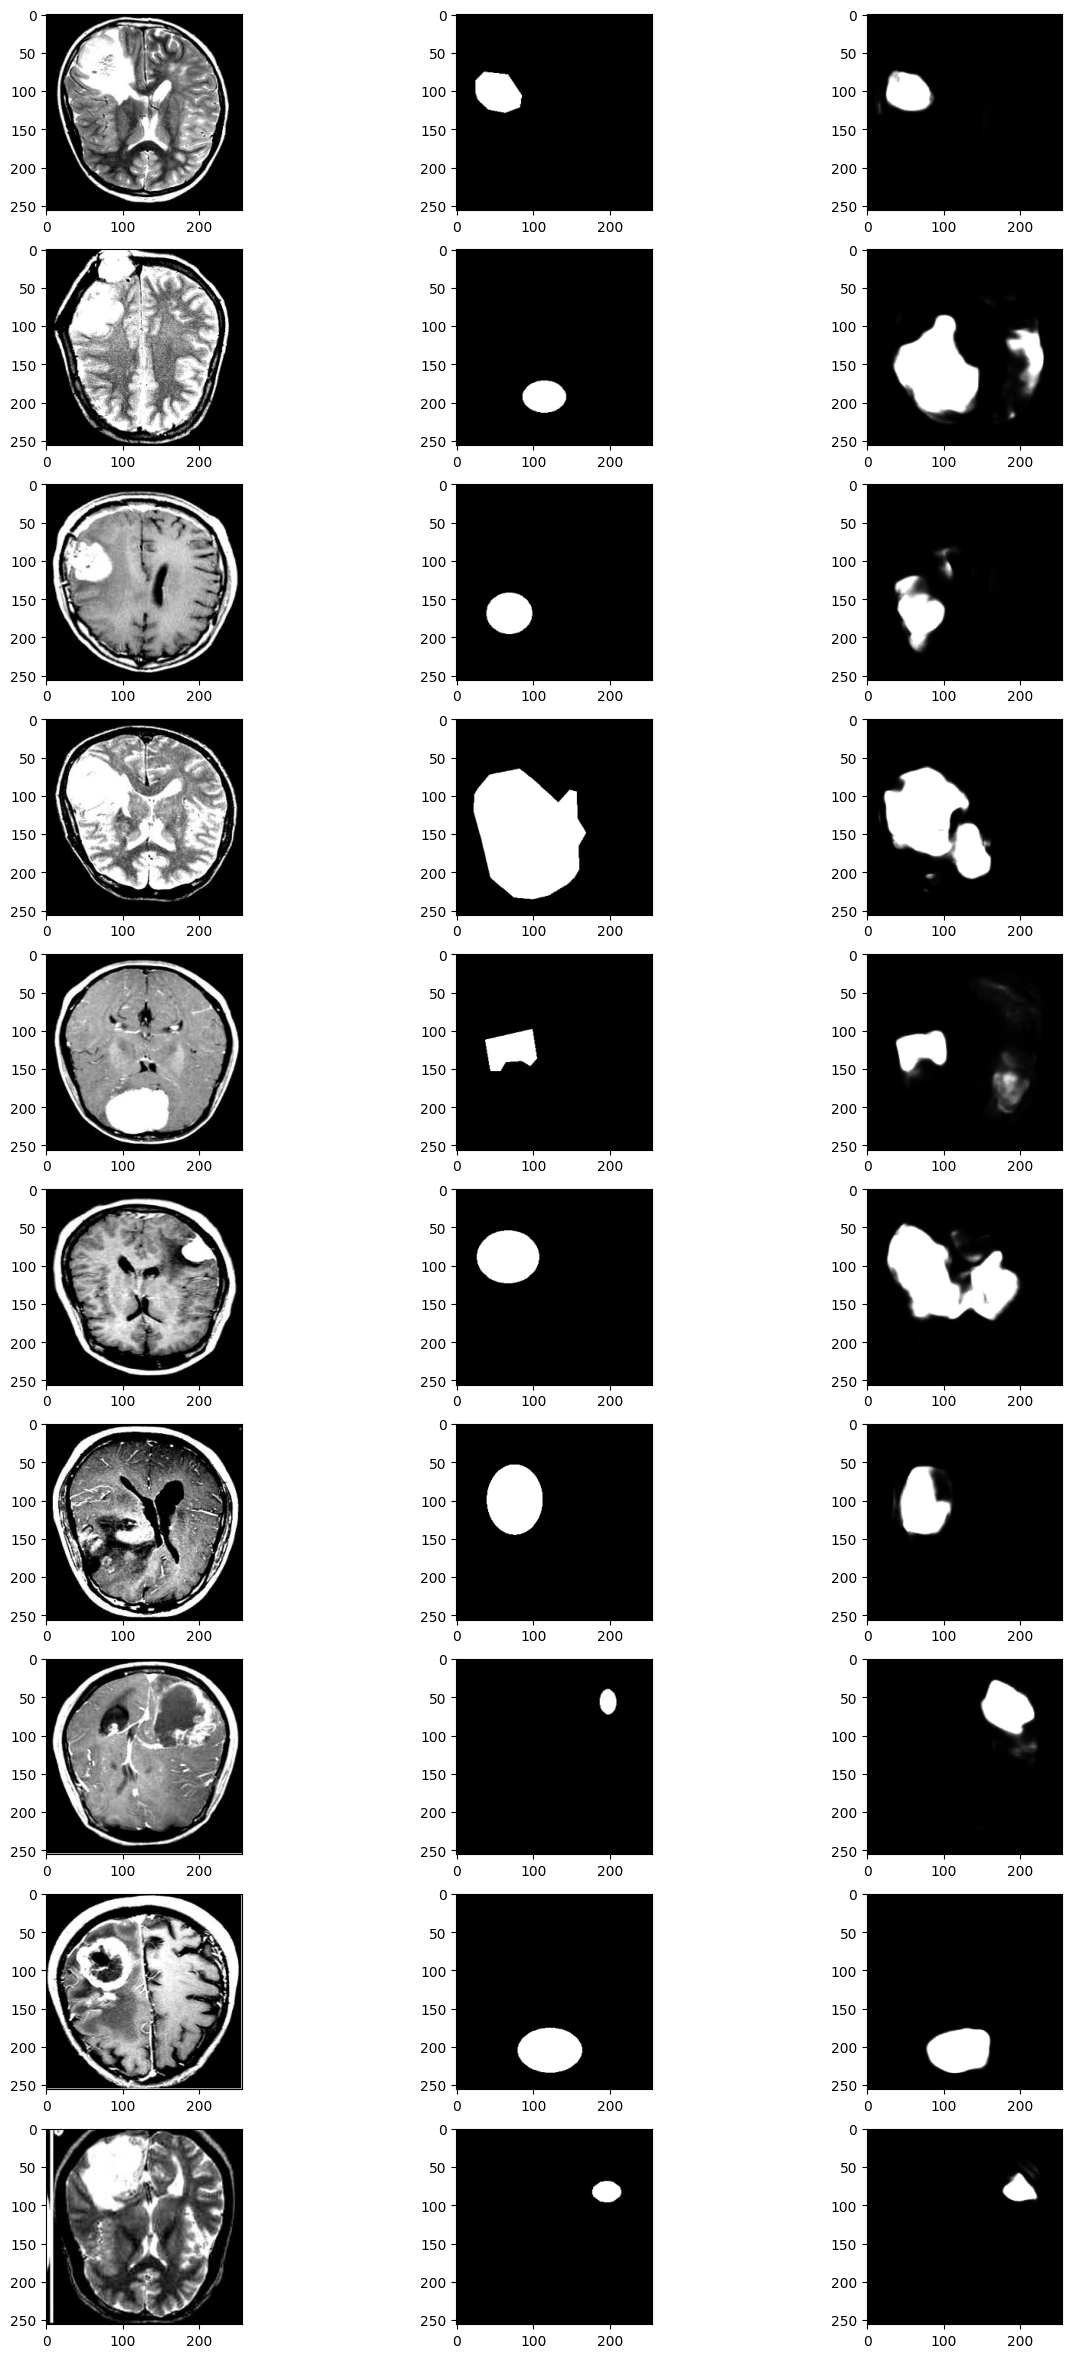

In [27]:
fig, ax = plt.subplots(10, 3, figsize=(15, 30))

for idx in range(10):
    ax[idx,0].imshow(Train_img[idx])
    ax[idx,1].imshow(Test_mask[idx],cmap = 'gray')
    ax[idx,2].imshow(predictions[idx],cmap = 'gray')

In [ ]:
import joblib

joblib.dump(history, '/content/gdrive/My Drive/model_CV_seg1.joblib')


In [ ]:
# # Load the model using joblib
# history = joblib.load('/content/gdrive/My Drive/my_model.joblib')

In [ ]:
b